### Preprocessing of 2014 Cushing, Oklahoma wastewater disposal and seismicity data

In this notebook, we will investigate the seismicity induced by underground wasterwater disposal in Cushing, Oklahoma during the year 2014. Let's begin by studying the spatial distribution of induced seismic events. At the centroid of the induced seismicity, we will evaluate time series of pressure and pressurization rate.

In [1]:
# Load relevant packages.
import utm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from orion_light.radial_flow import RadialFlowModel
from orion_light.pressure_table import PressureTableModel
from orion_light.seismic_catalog import SeismicCatalog

In [2]:
# Conversion factor from 1 year to 1 second
t_scale = 60*60*24*365.25 

In [3]:
# Boolean flag to decide whether to write data to GCP.
write_to_GCP = True

### 1. Seismic Data 

In [4]:
# Read in seismic data.
seismic_df = pd.read_csv('gs://us-geomechanicsforco2-landing/data_sources/cushing_2014_oklahoma/cushingSeismic.csv')

In [5]:
seismic_df.head(10)

,epoch,magnitude,longitude,latitude,depth,easting,northing
0,1.367956e+09,1.60,-96.74708,35.95636,3.308,703178.532034,3.981454e+06
1,1.367959e+09,1.43,-96.74708,35.95636,3.308,703178.532034,3.981454e+06
2,1.367965e+09,1.74,-96.75397,35.96083,2.536,702545.639896,3.981936e+06
3,1.368742e+09,1.37,-96.75089,35.95847,3.165,702829.475339,3.981681e+06
4,1.370684e+09,1.33,-96.77579,35.93718,5.000,700637.438947,3.979267e+06
5,1.370687e+09,1.17,-96.77579,35.93718,5.000,700637.438947,3.979267e+06
6,1.371269e+09,1.30,-96.77579,35.93718,5.000,700637.438947,3.979267e+06
7,1.381895e+09,1.47,-96.78317,35.93931,5.000,699966.244432,3.979488e+06
8,1.388010e+09,1.47,-96.78189,35.94675,4.908,700062.957628,3.980316e+06
9,1.388236e+09,2.17,-96.77901,35.94395,3.342,700329.832565,3.980012e+06


In [6]:
# Start time of seismic data
seismic_start = datetime.fromtimestamp(seismic_df['epoch'].min())

In [7]:
print('Do we have missing entries in our seismic data?') 
print(seismic_df.isnull().values.any())

Do we have missing entries in our seismic data?
False


The seismic data appear to be in good shape already. Let's save it directly to `staging` on GCP.

In [8]:
base_path = 'gs://us-geomechanicsforco2-dev-staging/temporal_datasets/cushing_2014_oklahoma'
if write_to_GCP:
    seismic_df.to_csv(base_path + '/seismic.csv', index=None)

In [9]:
# Prepare arrays for producing time series of cumulative earthquake counts.
t_vals_quakes = np.linspace(seismic_df['epoch'].min(), seismic_df['epoch'].max(), 100)
idx_quakes = np.digitize(seismic_df['epoch'], t_vals_quakes, right=False)

# Number of earthquakes per time bin
counts_per_bin = np.zeros(len(t_vals_quakes))
for n in range(1, len(t_vals_quakes)+1):
    counts_per_bin[n-1] = np.size(np.where(idx_quakes==n))
    
# Cumulative no. of earthquakes
cum_counts = np.cumsum(counts_per_bin)

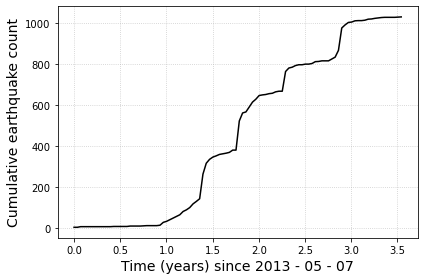

In [10]:
# Plot time series of cumulative earthquake counts.
fig = plt.figure(tight_layout=True)
plt.plot((t_vals_quakes-t_vals_quakes[0])/t_scale, cum_counts, '-k')
plt.xlabel('Time (years) since %s'% (seismic_start.strftime('%Y - %m - %d')), fontsize=14)
plt.ylabel('Cumulative earthquake count', fontsize=14)
plt.grid(linestyle=':', alpha=0.7)
plt.show()

In [11]:
# Compute centroid of induced seismicity as the arithmetic mean of coordinates of induced earthquakes. 
x_seismic_center = seismic_df['easting'].mean()
y_seismic_center = seismic_df['northing'].mean()
z_seismic_center = seismic_df['depth'].mean()

In [12]:
x_seismic_span = (seismic_df['easting'].max() - seismic_df['easting'].min())*1e-3
y_seismic_span = (seismic_df['northing'].max() - seismic_df['northing'].min())*1e-3
print('Easting range or x-span of induced seismicity = %.2f km'% (x_seismic_span))
print('Northing range or y-span of induced seismicity = %.2f km'% (y_seismic_span))

Easting range or x-span of induced seismicity = 6.37 km
Northing range or y-span of induced seismicity = 4.15 km


In [13]:
z_seismic_span = (seismic_df['depth'].max() - seismic_df['depth'].min())
print('Depth range or z-span of induced seismicity = %.2f m'% (z_seismic_span))
print('Minimum depth of seismic events = %.2f m'% (seismic_df['depth'].min()))
print('Maximum depth of seismic events = %.2f m'% (seismic_df['depth'].max()))

Depth range or z-span of induced seismicity = 4.80 m
Minimum depth of seismic events = 2.54 m
Maximum depth of seismic events = 7.33 m


In [14]:
t_seismic_span = (seismic_df['epoch'].max() - seismic_df['epoch'].min())/t_scale # years
print('Time span of seismic data = %.2f years'% (t_seismic_span))

Time span of seismic data = 3.54 years


### 2. Location of injection wells

In [15]:
well_loc_df = pd.read_csv('gs://us-geomechanicsforco2-landing/data_sources/cushing_2014_oklahoma/cushing_well_location.csv', delimiter=' ')

In [16]:
well_loc_df.head(10)

,longitude,latitude,easting,northing
0,-96.8062,35.9007,697984.8,3975158
1,-96.8385,35.9702,694898.6,3982803
2,-96.8336,36.0008,695265.0,3986208
3,-96.8007,36.0170,698190.3,3988071
4,-96.8474,35.9994,694024.4,3986025
5,-96.8747,35.9283,691735.3,3978083
6,-96.6609,35.9411,710992.6,3979944
7,-96.8201,36.0307,696407.8,3989552
8,-96.6589,35.9303,711201.7,3978751
9,-96.8987,35.9711,689467.5,3982784


In [17]:
N_wells = len(well_loc_df)
print('No. of wells in data set = %d'% (N_wells))

No. of wells in data set = 21


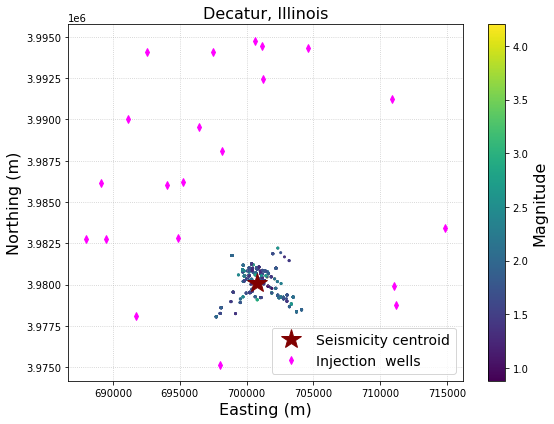

In [18]:
# Plot spatial distribution of induced earthquakes.
fig = plt.figure(figsize=(8,6))
im = plt.scatter(seismic_df['easting'], seismic_df['northing'], c=seismic_df['magnitude'], 
                 marker='o', s=4, cmap='viridis')
plt.plot(x_seismic_center, y_seismic_center, linestyle='None', marker='*', ms=20, color='maroon',
        label='Seismicity centroid')
plt.plot(well_loc_df['easting'], well_loc_df['northing'], linestyle='None', marker='d', ms=5, color='magenta', 
         label='Injection  wells')
plt.xlabel('Easting (m)', fontsize=16)
plt.ylabel('Northing (m)', fontsize=16)
h = plt.colorbar(im)
h.set_label('Magnitude', fontsize=16)
plt.legend(loc='best', prop={'size': 14})
plt.title('Decatur, Illinois', fontsize=16)
plt.grid(alpha=0.7, linestyle=':')
plt.tight_layout()
plt.show()

### 3. Injection flow rate data 

In [19]:
inj_csv = 'gs://us-geomechanicsforco2-landing/data_sources/cushing_2014_oklahoma/cushingInjection.csv'
inj_data = np.ascontiguousarray(pd.read_csv(inj_csv, header=None, delimiter=' ').to_numpy(copy=True))

In [20]:
inj_data.shape

(22, 277)

The first row of `inj_data` specifies the time of injection flow rate measurements in decimal years. Subsequent rows correspond to injection flow rates for wells 0 – 20.

In [21]:
t = np.copy(inj_data[0])
print(t[:10])

[1994.915 1995.    1995.085 1995.162 1995.247 1995.329 1995.414 1995.496
 1995.581 1995.666]


In [22]:
def convert_decimalyear_to_epoch(year: float, reference_year: int =1994) -> float:
    '''
    Convert time in decimal years to epoch values in seconds.
    
    Parameters:
    -------------
    year: float
        Decimal year (e.g., 1994.915)
    
    reference_year: integer
        Reference year (default: 1994)
    
    Returns:
    ------------
    epoch: float
        Epoch in seconds
    '''
    ref_datetime = datetime(reference_year, 1, 1)
    obj = ref_datetime + timedelta(days=(year-reference_year)*365.25)
    epoch = obj.timestamp()
    return epoch

In [23]:
epochs = np.zeros(len(t))
for i in range(len(t)):
    epochs[i] = convert_decimalyear_to_epoch(t[i])
print('Computed epochs in seconds. Printing first 10 epochs')
print(epochs[:10])

Computed epochs in seconds. Printing first 10 epochs
[7.86286404e+08 7.88968800e+08 7.91651196e+08 7.94081131e+08
 7.96763527e+08 7.99347650e+08 8.02030046e+08 8.04617770e+08
 8.07300166e+08 8.09982562e+08]


For convenience, let us assume zero depth for all wells.

In [24]:
z = np.zeros(N_wells)

In [25]:
# Construct list of dictionaries of well data.
wells = []
for i in range(N_wells):
    dict_data = {'x': well_loc_df.loc[i, 'easting'],
                 'y': well_loc_df.loc[i, 'northing'],
                 'z': z[i],
                 't': epochs.tolist(),
                 'q': inj_data[i+1].tolist()
                }
    wells.append(dict_data)

### 4. Use radial flow model to compute pressures and pressurization rates on a x-y-z-t grid.

In [26]:
flow_model = RadialFlowModel()
# Radial flow parameters 
flow_model.viscosity = 1.0
flow_model.permeability = 192.0 
flow_model.storativity = 1.2e-4
flow_model.payzone_thickness = 500.0
flow_model.setup_model(wells)

In [27]:
# Set up custom x-y-z-t grid.
x_grid = np.linspace(well_loc_df['easting'].min(),well_loc_df['easting'].max(), 100)
print('Along easting, we have %d grid samples with a spacing of %.2f km.'% (len(x_grid), (x_grid[1]-x_grid[0])*1.e-3))

y_grid = np.linspace(well_loc_df['northing'].min(),well_loc_df['northing'].max(), 100)
print('Along northing, we have %d grid samples with a spacing of %.2f km.'% (len(y_grid), (y_grid[1]-y_grid[0])*1.e-3))

z_grid = np.linspace(0., seismic_df['depth'].max(), 5)

t0 = min(epochs.min(), seismic_df['epoch'].min())
t1 = max(epochs.max(), seismic_df['epoch'].max())
t_grid = np.linspace(t0, t1, 300)
print('Grid shape (x, y, z, t) =', len(x_grid), len(y_grid), len(z_grid), len(t_grid))

G = np.meshgrid(x_grid, y_grid, z_grid, t_grid, indexing='ij')

Along easting, we have 100 grid samples with a spacing of 0.27 km.
Along northing, we have 100 grid samples with a spacing of 0.20 km.
Grid shape (x, y, z, t) = 100 100 5 300


In [28]:
#p = flow_model.p(*G)
#dpdt = flow_model.p(*G)

In [29]:
# TO DO: Write spatiotemporal data products (p and dp/dt)  to file. 

### 5. Evaluate pressure and `dp/dt` at the centroid of induced seismicity.

In [30]:
G_centroid = np.meshgrid(np.array([x_seismic_center]), np.array([y_seismic_center]),
                         np.array([z_seismic_center]), t_grid, indexing='ij')

In [31]:
# Evaluate pressure and dp/dt at seismicity centroid using flow model.
p_centroid = flow_model.p(*G_centroid).squeeze()
dpdt_centroid = flow_model.dpdt(*G_centroid).squeeze()
print('Pressure and dp/dt computed.')

Pressure and dp/dt computed.


In [32]:
# Write temporal data set to GCP.
if write_to_GCP:
    pressure_df = pd.DataFrame({'epoch': t_grid, 'pressure': p_centroid, 'dpdt': dpdt_centroid})
    pressure_df.to_csv(base_path+'/pressure.csv',index=None)
    print('Write to GCP finished.')

Write to GCP finished.


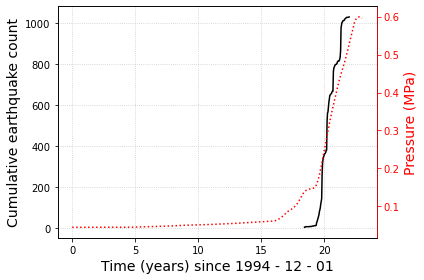

In [33]:
t0_date = datetime.fromtimestamp(t0)

# Plot pressure time series alongside that of cumulative earthquake counts.
fig, ax = plt.subplots(nrows=1, ncols=1, tight_layout=True)
# Cumulative earthquake counts
ax.plot((t_vals_quakes-t0)/t_scale, cum_counts, '-k')
ax.grid(linestyle=':', alpha=0.7)
ax.set_xlabel('Time (years) since %s'% (t0_date.strftime('%Y - %m - %d')), fontsize=14)
ax.set_ylabel('Cumulative earthquake count', fontsize=14)
# Pressure data
ax2 = ax.twinx()
ax2.plot((t_grid-t0)/t_scale, p_centroid*1.0e-6, ':r')
ax2.set_ylabel('Pressure (MPa)', fontsize=14, color='r')
ax2.spines['right'].set_color('red')
ax2.tick_params(axis='y', colors='red')
plt.show()

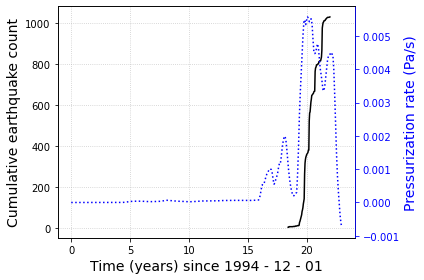

In [34]:
# Plot pressurization rate time series alongside that of cumulative earthquake counts.
fig, ax = plt.subplots(nrows=1, ncols=1, tight_layout=True)
# Cumulative earthquake counts
ax.plot((t_vals_quakes-t0)/t_scale, cum_counts, '-k')
ax.grid(linestyle=':', alpha=0.7)
ax.set_xlabel('Time (years) since %s'% (t0_date.strftime('%Y - %m - %d')), fontsize=14)
ax.set_ylabel('Cumulative earthquake count', fontsize=14)
# Pressure data
ax2 = ax.twinx()
ax2.plot((t_grid-t0)/t_scale, dpdt_centroid, ':b')
ax2.set_ylabel('Pressurization rate (Pa/s)', fontsize=14, color='b')
ax2.spines['right'].set_color('b')
ax2.tick_params(axis='y', colors='b')
plt.show()